# Modeling and forecasting of twitter volume timeseries
After understanding our data in the previous section, [descriptive statistics](../part2/descriptive_stats.ipynb), we now want to quickly run a time-series forecast using [gluonts](https://github.com/awslabs/gluon-ts).
In this example we use the same dataset as before and create first a baseline (seasonal naive estimator). Afterwards we create and train a [DeepAR](https://arxiv.org/abs/1704.04110) model and compare it to the baseline. 

Let's first install and check that GluonTS is installed and that we have the correct MXNet version:

In [ ]:
! pip install gluonts --upgrade
! pip install --upgrade sagemaker>=2.89.0
! pip install sagemaker-experiments
! pip install --upgrade smdebug-rulesconfig

In [1]:
import mxnet
import gluonts
print(mxnet.__version__)

1.9.0


If your MXNet version is not 1.4.1 or GluonTS is not installed, then please uncomment and execute the following lines.

In [2]:
#! pip install mxnet==1.4.1
#! pip install gluonts

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mxnet import gpu, cpu
from mxnet.context import num_gpus
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.dataset.common import ListDataset
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions, backtest_metrics
import pathlib
import json
import boto3
import csv

### Setting up hyperparameters
Here we just set the number of epochs and rely on default values for the rest of the parameters in order to make the example more understandable.

In [5]:
EPOCHS = 20

### Loading the data

In [6]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"

In [7]:
df = pd.read_csv(filepath_or_buffer=url, header=0, index_col=0)
df.head()

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93


<AxesSubplot:xlabel='timestamp'>

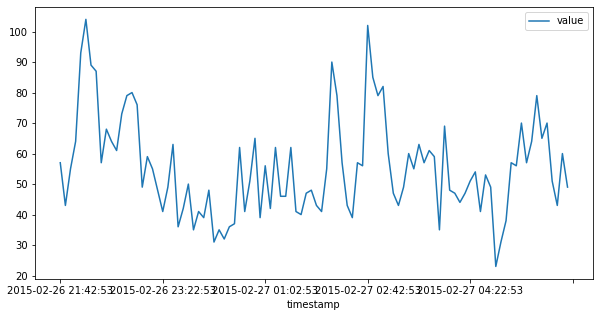

In [8]:
df[:100].plot(figsize=(10,5))

### Plotting forecast helper function
Often it is interesting to tune or evaluate the model by looking at error metrics on a hold-out set. For other machine learning tasks such as classification, one typically does this by randomly separating examples into train/test sets. For forecasting it is important to do this train/test split in time rather than by series.

The below function plots a forecast for a given data and a given predictor. Let's dive deeper into components of this funciton.
`from gluonts.model` includes a number of implemented models. Each model has an estimator. An estimator accepts a series of models and hyperparameters. Parameters include a trainer that accepts optimization parameters. The estimator also accepts parameters such as context (CPU, GPU), number of layers, context length, time-series frequency, and prediction length amongst others. The context length defines how many past time steps will be taken into account to make a prediction. The default value is the prediction_length.

The estimator has a `train` method that is used for fitting the data. The `train` method returns a predictor that can be used to forecast based on input data.

`plot_forecast` function accepts a `predictor` object and an iterable dataset to plot the data and the forecast.
It will call `make_evaluation_predictions` that takes the predictor and test_data and creates the forecasts.

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
def plot_forecast(predictor, test_data):
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data,  
        predictor=predictor,  
        num_samples=100,  
    )
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    list(ts_it)[0][-336:].plot(ax=ax)  
    list(forecast_it)[0].plot(prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

### Dataset
`gluonts.dataset.common` has a class `ListDataset`. GluonTS does not require this specific format for a custom dataset that a user may have. The only requirements for a custom dataset are to be iterable and have a "target" and a "start" field. To make this more clear, assume the common case where a dataset is in the form of a `numpy.array` and the index of the time series in a `pandas.Timestamp`. 

In this example we are using a `gluonts.dataset.common.ListDataset`. A `ListDataset` consist of a list of of dictionaries with the following format:
```
{'start': Timestamp('2019-07-26 00:00:00', freq='D'),
  'cat': [5, 4, 42, 17, 0, 0, 0],
  'target': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0.], dtype=float32)},
 {'start': Timestamp('2019-07-26 00:00:00', freq='D'),
  'cat': [8, 7, 32, 13, 0, 0, 0],
  'target': array([4., 3., 5., 2., 5., 2., 3., 7., 4., 3., 3., 2.], dtype=float32)}
```
Each dictionary contains one time series and we need to pass *start* as `pandas.index` and a *target* as an iterable set of timestamp values from our pandas dataframe. We can also indicate categorical features in the field `cat`.

In the followng cell we build a training dataset ending at April 5th, 2015 and a test dataset that will be used forecast the hour following the midnight on April 15th, 2015. GluonTS requires the full timeseries to be in the test dataset. So test and train data will start at February 26 2015. GluonTS will then cut out the `n` last elements from test dataset, in order to predict those. `n` is equal the prediction length. 

In [10]:
training_data = ListDataset([{"start": df.index[0], 
                              "target": df.value[: "2015-04-05 00:00:00"]}], 
                              freq="5min")

test_data = ListDataset([{"start": df.index[0], 
                          "target": df.value[:"2015-04-15 00:00:00"]}], 
                          freq="5min")

## Create a baseline: seasonal naive predictor

Before training complex deep learning models, it is best to come up with simple base models. Such a baseline could for instance be: that the future volumes will be the same like in the last 5 minutes. This naive estimation works remarkably well for many economic and financial time series. Because a naïve forecast is optimal when data follows a random walk, these are also called random walk forecasts

GluonTS provides a [seasonal naive predictor](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.seasonal_naive.html). The seasonal naive method sets each forecast to be equal to the last observed value from the same season. So the model assumes that the data has a fixed seasonality (in this case, 300 time steps correspond to nearly a day), and produces forecasts by copying past observations based on it.


In [11]:
from gluonts.model.seasonal_naive import *
from gluonts.evaluation import Evaluator

naive_predictor = SeasonalNaivePredictor(freq='5min', 
                                         prediction_length=36,
                                         season_length=300)

Below we are using [gluonts.evaluation.Evaluator](https://gluon-ts.mxnet.io/api/gluonts/gluonts.evaluation.html) to create an aggregated evaluation metrics of the model we have trained. It produces some commonly used error metrics such as MSE, MASE, symmetric MAPE, RMSE, and (weighted) quantile losses. 

The Evaluator returns both a dictionary and a pandas DataFrame. You can use the python dictionary, first output, or the pandas DataFrame, the second output, depending on what you would like to do. The dictionary item includes more values.

In [12]:
forecast_it_baseline, ts_it_baseline = make_evaluation_predictions(test_data, naive_predictor,  num_samples=100)
forecasts_baseline = list(forecast_it_baseline)
tss_baseline = list(ts_it_baseline)
evaluator = Evaluator()
agg_metrics_baseline, item_metrics = evaluator(iter(tss_baseline), iter(forecasts_baseline), num_series=len(test_data))

/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/dataset/util.py:32: Futur

Now we plot the forecasts and we can see that the naive estimator just copies the values from last day. It will also just give single point forecast.

/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/dataset/util.py:32: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return ts + ts.freq * amount


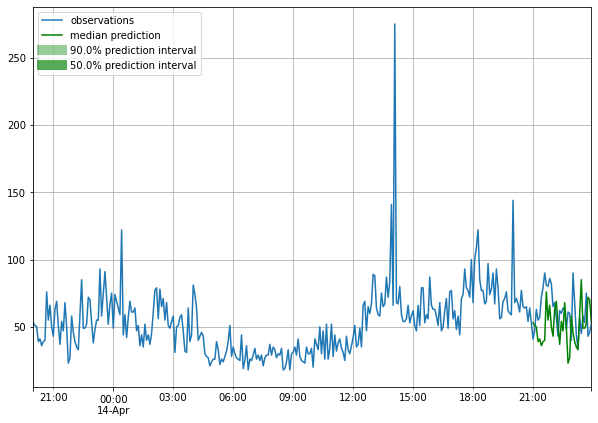

In [13]:
plot_forecast(naive_predictor, test_data)

Print the baseline metrics:

In [14]:
agg_metrics_baseline

{'MSE': 538.0833333333334,
 'abs_error': 675.0,
 'abs_target_sum': 2189.0,
 'abs_target_mean': 60.80555555555556,
 'seasonal_error': 19.32311178247734,
 'MASE': 0.9703406061648387,
 'MAPE': 0.30172369215223527,
 'sMAPE': 0.335599872801039,
 'MSIS': 38.81362424659355,
 'QuantileLoss[0.1]': 386.2,
 'Coverage[0.1]': 0.3333333333333333,
 'QuantileLoss[0.2]': 458.4,
 'Coverage[0.2]': 0.3333333333333333,
 'QuantileLoss[0.3]': 530.6,
 'Coverage[0.3]': 0.3333333333333333,
 'QuantileLoss[0.4]': 602.8,
 'Coverage[0.4]': 0.3333333333333333,
 'QuantileLoss[0.5]': 675.0,
 'Coverage[0.5]': 0.3333333333333333,
 'QuantileLoss[0.6]': 747.2000000000002,
 'Coverage[0.6]': 0.3333333333333333,
 'QuantileLoss[0.7]': 819.4,
 'Coverage[0.7]': 0.3333333333333333,
 'QuantileLoss[0.8]': 891.6,
 'Coverage[0.8]': 0.3333333333333333,
 'QuantileLoss[0.9]': 963.7999999999998,
 'Coverage[0.9]': 0.3333333333333333,
 'RMSE': 23.19662331748596,
 'NRMSE': 0.38148855158953615,
 'ND': 0.3083599817268159,
 'wQuantileLoss[0.1

Which metric to choose depends on your business use case. For instance is underestimation more problematic than overestimation?

For instance, the lower the Root-Mean-Squared Error (RMSE) the better - a value of 0 would indicate a perfect fit to the data. But RMSE is dependent on the scale of the data being used. Dividing the RMSE by the range of the data, gives an average error as a proportion of the data's scale. This is called the Normalized Root-Mean-Squared Error (NRMSE). However, the RMSE and NRMSE are very sensitive to outliers. 

Percentage errors like MAPE, sMAPE are unit-free and are frequently used to compare forecast performances between data sets.

## DeepAR 

Amazon SageMaker DeepAR is a methodology for producing accurate probabilistic forecasts, based on training an auto-regressive recurrent network model on a large number of related time series. DeepAR produces more accurate forecasts than other state-of-the-art methods, while requiring minimal manual work.

* The DeepAR algorithm first tailors a `Long Short-Term Memory` ([LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory))-based recurrent neural network architecture to the data. DeepAR then produces probabilistic forecasts in the form of `Monte Carlo` simulation. 
* `Monte Carlo` samples are empirically generated pseudo-observations that can be used to compute consistent quantile estimates for all sub-ranges in the prediction horizon.
* DeepAR also uses item-similarity to handle the `Cold Start` problem, which is to make predictions for items with little or no history at all.

In this notebook you will learn how to use GluonTS to train a DeepAR model on your own dataset and a very detailed understanding of the implementation details of DeepAR won't be necessary. But if you you would like to learn more about DeepAR, then check out [this](../part4/deepar_details.ipynb) notebook or the [paper](https://arxiv.org/abs/1704.04110).

To train a DeepAR in GluonTS, we first need to create an estimator object. An estimator object represents the network, contains a trainer, which in turn includes batch size, initializer, context, learning rate and other training specific hyperparameters. The estimator object also includes frequency of timestamp, prediction length to express how many steps we want to predict, and structural parameters such as number of layers. The estimator also crucially includes a `train` method. The train method is used to fit a model to a given dataset and returns a predictor object, which can be used to predict/forecast values.

The frequnecy parameter needs to be the same as accepted frequencies by pandas. For more information on pandas use of frequency please refer to the [documentation of pandas date_range.](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html)

Finally the `prediction_length` is set to 36. We aim to predict tweets for the next 3 hours and as the data has `freq=5min`, we opt 36 steps, which is 36x5min = 180min or three hours.

In [16]:
from gluonts.mx.distribution import DistributionOutput, StudentTOutput

deepar_estimator = DeepAREstimator(freq="5min", 
                                   prediction_length=36,
                                   distr_output=StudentTOutput(),
                                   trainer=Trainer(epochs=EPOCHS))

DeepAR has a lot of different hyperparameters and in [lab 4](../part4/twitter_volume_sagemaker.ipynb) we will tune some of them. In this notebook we will just use the default values.


We simply call `train` method of the `deepar_estimator` we just created and pass our iterable training data to the train method. The output is a predictor object.  

In [17]:
deepar_predictor = deepar_estimator.train(training_data=training_data)

/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
  0%|          | 0/50 [00:00<?, ?it/s]/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/home/alfred/anaconda3/envs/aws/lib/pytho

### Test the model

We use the `plot_forecast` function that was implemented earlier in this notebook and pass predictor object and test data. You will notice the green print in the forecast in different confidence intervals.

/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


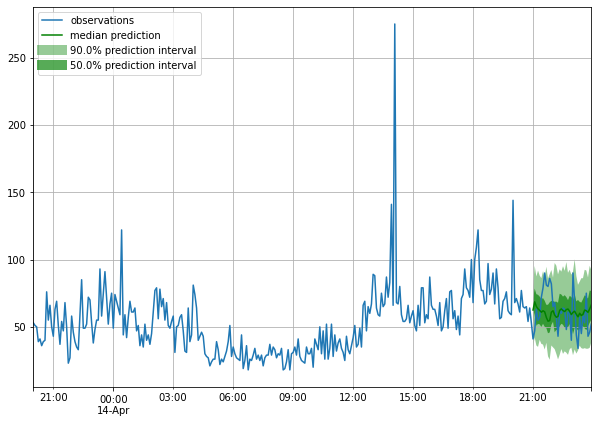

In [18]:
plot_forecast(predictor=deepar_predictor, test_data=test_data)

### Save the model
Both training and prediction networks can be saved using `estimator.serialize_prediction_net` and `estimator.serialize` respectively.

In [19]:
import os
os.makedirs('deepar', exist_ok=True)
deepar_predictor.serialize_prediction_net(pathlib.Path('deepar'))
deepar_predictor.serialize(pathlib.Path('deepar'))

### Evaluation
Below we are using `gluonts.evaluation.Evaluator` to create an aggregated evaluation metrics of the model we have trained. The `Evaluator` accepts predictions and calculates multiple evaluation metrics such as "MSE" and "Quantile Loss". The `Evaluator` returns both a dictionary and a pandas DataFrame. You can use the python dictionary, first output, or the pandas DataFrame, the second output, depending on what you would like to do. The dictionary item includes more values.

In [20]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

forecast_it, ts_it = make_evaluation_predictions(dataset=test_data, 
                                                        predictor=deepar_predictor, 
                                                        num_samples=100)
deepar_agg_metrics, item_metrics = Evaluator(quantiles=[0.1, 0.5, 0.9])(
                                                ts_it, 
                                                forecast_it, 
                                                num_series=len(training_data))
deepar_agg_metrics

Running evaluation:   0%|          | 0/1 [00:00<?, ?it/s]/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future ver

{'MSE': 257.4562717013889,
 'abs_error': 465.768798828125,
 'abs_target_sum': 2189.0,
 'abs_target_mean': 60.80555555555556,
 'seasonal_error': 19.32311178247734,
 'MASE': 0.6695620423519284,
 'MAPE': 0.2258367273542616,
 'sMAPE': 0.21432816982269287,
 'MSIS': 3.822895261782617,
 'QuantileLoss[0.1]': 171.01375045776368,
 'Coverage[0.1]': 0.05555555555555555,
 'QuantileLoss[0.5]': 465.76880264282227,
 'Coverage[0.5]': 0.5833333333333334,
 'QuantileLoss[0.9]': 226.70314178466793,
 'Coverage[0.9]': 0.8888888888888888,
 'RMSE': 16.045443954636745,
 'NRMSE': 0.2638812162480232,
 'ND': 0.21277697525268388,
 'wQuantileLoss[0.1]': 0.0781241436536152,
 'wQuantileLoss[0.5]': 0.2127769769953505,
 'wQuantileLoss[0.9]': 0.10356470616019549,
 'mean_absolute_QuantileLoss': 287.8285649617513,
 'mean_wQuantileLoss': 0.13148860893638706,
 'MAE_Coverage': 0.046296296296296335,
 'OWA': nan}

We can see that DeepAR produces much better predictions than the naive estimator. 

In [21]:
print(deepar_agg_metrics["MSE"],agg_metrics_baseline["MSE"])

257.4562717013889 538.0833333333334


If you still have time left you can proceed to the next section, where you will train a multi layer perceptron.

### Additional: Comparison with Mulitlayer Perceptron
We now use another estimator, `SimpleFeedForwardEstimator`, to make the same forecast. This model is using a simple MLP or a feed forward network to reach the same goal. At the end we shall compare the results of the models.

In [22]:
mlp_estimator = SimpleFeedForwardEstimator(freq="5min", 
                                           prediction_length=36, 
                                           trainer=Trainer(epochs=EPOCHS))
mlp_predictor = mlp_estimator.train(training_data=training_data)

  0%|          | 0/50 [00:00<?, ?it/s]/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|██████████| 50/50 [00:00<00:00, 85.68it/s, epoch=20/20, avg_epoch_loss=4.4]


/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


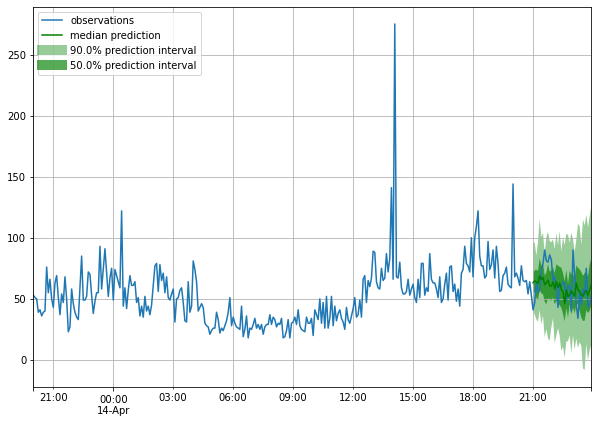

In [23]:
plot_forecast(predictor=mlp_predictor, test_data=test_data)


The code snippet below, is using the same mechanism we have used before for evaluation, except the function accepts data and a list of predictors as well as a textual name for the predictors to use as column name in the pandas DataFrame output. It then loops over predictors, performs evaluation, converts the evaluation dictionary into a pandas DataFrame, and appends the output of evaluation to a dataframe as as a new column.

In [24]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
def evaluat_models_from_dict(data, predictors, predictor_names, num_samples=100):
    '''
    Comparing results of multiple models.
    Parameters:
        data: the dataset on which we are performing the evaluation.
        predictors: A list of predictor objects
        predictor_names: A list of textual names for the predictors that have an ordered one-to-one
                         relationship with the predictors.
        num_samples (default=100): what sample size from the evaluation dataset.
    Output: pandas dataframe to an evaluation column per predictor.
    '''
    df = pd.DataFrame()
    for (predictor, predictor_name) in zip(predictors, predictor_names):
        forecast_it, ts_it = make_evaluation_predictions(data, 
                                                        predictor=predictor, 
                                                        num_samples=num_samples)
        deepar_agg_metrics, item_metrics = Evaluator(quantiles=[0.1, 0.5, 0.9])(
                                                     ts_it, 
                                                     forecast_it, 
                                                     num_series=len(data))
               
        evaluation = pd.DataFrame.from_dict(deepar_agg_metrics, orient='index', columns=[predictor_name])
        if df.empty:
            df = evaluation.copy()
        else:
            df.insert(loc=len(df.columns), column=predictor_name, value=evaluation.values)
    return df
evaluat_models_from_dict(data=test_data, 
               predictors=[deepar_predictor, mlp_predictor, naive_predictor], 
               predictor_names = ['deepar', 'mlp', 'naive predictor'])

Running evaluation:   0%|          | 0/1 [00:00<?, ?it/s]/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]/home/alfred/anaconda3/envs/aws/lib/python3.8/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future ver

,deepar,mlp,naive predictor
MSE,227.870253,208.063368,538.083333
abs_error,451.048584,447.930847,675.000000
abs_target_sum,2189.000000,2189.000000,2189.000000
abs_target_mean,60.805556,60.805556,60.805556
seasonal_error,19.323112,19.323112,19.323112
MASE,0.648401,0.643919,0.970341
MAPE,0.226714,0.213194,0.301724
sMAPE,0.207117,0.207841,0.335600
MSIS,3.701494,5.678240,38.813624
QuantileLoss[0.1],161.350823,238.403745,386.200000


### Additional: Accessing weights and model parameters
You can get access to the network structure and parameters. `DeepARNetwork` is derived from `mxnet.gluon.block.HybridBlock`. 

In [25]:
gluonts.model.deepar._network.DeepARTrainingNetwork.__bases__[0].__bases__[0]

mxnet.gluon.block.HybridBlock

We can now call `DeepARTrainingNetwork.collect_params()`, which returns a `mxnet.gluon.parameter.ParameterDict` object. for more information how to query `ParameterDict`, plese refer to [mxnet documentation.](https://mxnet.incubator.apache.org/api/python/gluon/gluon.html#mxnet.gluon.ParameterDict)

In [26]:
deepar_predictor.prediction_net.collect_params() 

deeparpredictionnetwork0_ (
  Parameter deeparpredictionnetwork0_None_distr_mu_weight (shape=(1, 40), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_None_distr_mu_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_None_distr_sigma_weight (shape=(1, 40), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_None_distr_sigma_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_None_distr_nu_weight (shape=(1, 40), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_None_distr_nu_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_lstm0_i2h_weight (shape=(160, 43), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_lstm0_h2h_weight (shape=(160, 40), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_lstm0_i2h_bias (shape=(160,), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_lstm0_h2h_